### **Premier League Game Analysis**



By: Mohamed Aamir and Dilan Gunawardana

Motivating Question: What makes football teams in Premier League successful and can we predict their level of success?

Link to .ipynb file can be found here: https://github.com/Dgunawardana/Dgunawardana.github.io

In this project, we look at analyzing one of the most popular European football leagues - the English Premier League, also known as the Premier League or the EPL.

Let me start with a brief description of the EPL. The Premier league is the top tier football league in England. Our North American friends may refer to this sport as 'soccer'. It was formed in 1992 and is currently one of the most watched sports league around the world. In fact according to some websites, it is the most watched sports league in the world.

The competition takes place annually. It involves 20 teams playing each other twice - once at home and once away from home. So, every team plays 19 other teams twice, which means that each of the 20 teams play 38 games a season.

A team is awarded 3 points for a win, 1 point for a draw or a tie, and 0 points for a loss. The team that ends up with the most points at the end of the season wins the Premier League trophy for that year. If two teams have the same number of points on the league table, the team with the higher goal difference gets the higher rank. Goal difference is basically the difference between the number of goals scored and the number of goals conceded. The goal difference of a team becomes higher if that team scores a lot of goals, or concedes very few goals, or both.

Let us consider an example. Suppose that 10 games have been played in the premier league. Team A has won 5, drawn 3, and lost 2. Let us denote this as 5-3-2 for short. At the end of 10 games, Team A would have 5\*3 + 3\*1 = 18 points. Team B is 4-6-0 at the end of 10 games. Team B would also have 18 points. Suppose that Team A has scored a total of 15 goals and conceded a total of 18 goals in the first 10 games, giving it a goal difference of 15-18 = -3. Suppose Team B has scored 23 and conceded 17, having a goal difference of 5. Team B would be higher up the table due to the higher goal difference.





In [90]:
#Import the relevant libraries

import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
import requests
import os
import re
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import svm
from sklearn import tree
from sklearn import neighbors
import random

In [91]:
#We just clean up colab's virtual machine by removing unnecessary files

#Unix commands are preceded with a "!" and this code just navigates to the home
#(/content) directory to delete the sample_data folder if it exists
!cd ~
!if [ -d sample_data ]; then rm -r sample_data; fi

In this cell, we retrieve the csv files for the data about Premier League 
soccer matches in the past decade. There are multiple csv files (one for
each year's season) so we automate the procedure of downloading all files
by using a webscraper that downloads all csv files to the /content folder. After using the request api, we parse the html page of this website and extract the links to download the csv files.

In [92]:
#This is the website that provides the csv files for the game data:
#https://datahub.io/sports-data/english-premier-league
#Note that the translation of the column labels can be found here:
#https://github.com/woobe/footballytics/blob/master/data/notes.txt

#We need to request the html page from the link using the requests library
ws = requests.get("https://datahub.io/sports-data/english-premier-league")
#We use beautiful soup to read in this html page
soup = BeautifulSoup(ws.content, 'html.parser')

#All of the relevant download links are in html elements whose class name is
#"download truncate col-xs-4" so we want a list of these elements
links = soup.find_all(class_="download truncate col-xs-4")
#We store the names of the csv files in a list for reference later
csv_names = []
#Iterate through all the html elements which have the download link
for l in links:
  #In each of these html elements:
  #If the html element has links and if those links end in "csv"
  if l.find_all("a")[0] and l.find_all("a")[0]['href'][-3:] == "csv":
    #'fpath' is the download link
    fpath = "https://datahub.io" + l.find_all("a")[0]['href']
    #'fname' will be the name of the csv file
    fname = "." + re.findall("\/[^\/]+$",l.find_all("a")[0]['href'])[0]
    #Add names to name list
    csv_names.append(fname)
    print(fpath)
    #Only download if the file doesn't already exist
    if not os.path.exists(fname):
      #os.system() allows us to run system commands without "!"
      #We download the csv file (to /content) using linux's "wget" command
      os.system(f"wget {fpath}")
    else: #if this file has already been downloaded
      print(f"File {fname} is already downloaded")


https://datahub.io/sports-data/english-premier-league/r/season-1819.csv
File ./season-1819.csv is already downloaded
https://datahub.io/sports-data/english-premier-league/r/season-1718.csv
File ./season-1718.csv is already downloaded
https://datahub.io/sports-data/english-premier-league/r/season-1617.csv
File ./season-1617.csv is already downloaded
https://datahub.io/sports-data/english-premier-league/r/season-1516.csv
File ./season-1516.csv is already downloaded
https://datahub.io/sports-data/english-premier-league/r/season-1415.csv
File ./season-1415.csv is already downloaded
https://datahub.io/sports-data/english-premier-league/r/season-1314.csv
File ./season-1314.csv is already downloaded
https://datahub.io/sports-data/english-premier-league/r/season-1213.csv
File ./season-1213.csv is already downloaded
https://datahub.io/sports-data/english-premier-league/r/season-1112.csv
File ./season-1112.csv is already downloaded
https://datahub.io/sports-data/english-premier-league/r/season-1

Unfortunately, the data doesn't naturally come in a useful form for data 
analysis (since data is spread across multiple csv files), so we do a bit of 
data cleaning by combining all the csv files into one unified dataframe and 
including a couple of extra columns to indicate the years of the season.

In [93]:
#This will contain a list of the pandas dataframe versions of each csv file
dfs = []
#Make the data in chronological order (increasing time)
csv_names.reverse() 

#Iterate through all of the csv file names
for c in csv_names:
  #"c" is the name of a csv file containing soccer game data for a single season

  #Note that file name comes in the form "season-YYYY.csv"
  #Where the first 2 Y's (c[9:11]) correspond to starting year
  #and the second 2 Y's (c[11:13]) correspond to ending year
  season_start = int("20"+c[9:11])
  season_end = int("20"+c[11:13])
  #Use the inbuilt pandas read_csv to convert from csv to dataframe
  df = pd.read_csv(c)
  #Create two new columns that have the years of the season start and end 
  #respectively for all rows in this year's dataframe
  df['season_start'] = season_start
  df['season_end'] = season_end
  #Add this season's dataframe to list of soccer game dataframes
  dfs.append(df)

#Use pandas concat function to vertically stack all of the dataframes from the
#'dfs' list into one unified dataframe
game_dataframe = pd.concat(dfs,ignore_index=True)
game_dataframe.head(20)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,GBH,GBD,GBA,IWH,IWD,IWA,LBH,LBD,LBA,SBH,SBD,SBA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,BSH,BSD,BSA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,season_start,season_end,PSH,PSD,PSA,PSCH,PSCD,PSCA
0,E0,2009-08-15,Aston Villa,Wigan,0,2,A,0,1,A,M Clattenburg,11,14,5,7,15,14,4,6,2,2,0,0,1.67,3.60,5.50,1.65,3.40,5.00,1.67,3.50,5.25,1.70,3.50,4.90,1.67,3.30,4.50,1.65,3.40,5.00,1.70,3.40,5.50,1.67,3.60,5.50,1.70,3.40,5.00,1.62,3.50,5.50,37,1.72,1.66,3.77,3.51,6.05,5.33,32,2.04,1.92,1.91,1.81,21.0,0.0,1.28,1.22,4.40,3.99,2009,2010,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,2009-08-15,Blackburn,Man City,0,2,A,0,1,A,M Dean,17,8,9,5,12,9,5,4,2,1,0,0,3.60,3.25,2.10,3.40,3.15,2.00,3.40,3.25,2.10,3.20,3.20,2.20,3.00,3.20,2.10,3.15,3.25,2.10,3.50,3.20,2.15,3.30,3.25,2.20,3.25,3.20,2.20,3.30,3.20,2.20,38,3.78,3.37,3.35,3.24,2.25,2.12,33,2.15,2.04,1.78,1.71,24.0,0.0,2.58,2.38,1.60,1.54,2009,2010,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,2009-08-15,Bolton,Sunderland,0,1,A,0,1,A,A Marriner,11,20,3,13,16,10,4,7,2,1,0,0,2.25,3.25,3.25,2.15,3.15,3.15,2.25,3.25,3.10,2.20,3.20,3.20,2.10,3.20,3.00,2.25,3.20,2.90,2.30,3.20,3.20,2.30,3.25,3.10,2.25,3.20,3.10,2.20,3.20,3.30,38,2.37,2.24,3.31,3.20,3.40,3.15,33,2.25,2.12,1.70,1.66,23.0,0.0,1.68,1.61,2.33,2.23,2009,2010,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,2009-08-15,Chelsea,Hull,2,1,H,1,1,D,A Wiley,26,7,12,3,13,15,12,4,1,2,0,0,1.17,6.50,21.00,1.17,6.00,13.00,1.20,6.00,15.00,1.20,5.50,14.00,1.17,5.50,12.00,1.17,5.75,15.00,1.17,6.50,21.00,1.18,6.50,17.00,1.17,6.00,17.00,1.20,5.50,19.00,38,1.20,1.17,7.71,6.26,23.14,16.39,34,1.67,1.58,2.44,2.26,22.0,0.0,1.03,1.02,17.05,12.96,2009,2010,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,2009-08-15,Everton,Arsenal,1,6,A,0,3,A,M Halsey,8,15,5,9,11,13,4,9,0,0,0,0,3.20,3.25,2.30,2.95,3.15,2.25,3.00,3.25,2.30,3.10,3.10,2.30,2.88,3.00,2.25,3.00,3.20,2.20,3.20,3.20,2.30,3.25,3.25,2.25,2.90,3.30,2.30,3.25,3.20,2.20,38,3.34,3.07,3.34,3.21,2.42,2.28,34,2.20,2.06,1.77,1.70,24.0,0.0,2.27,2.20,1.73,1.63,2009,2010,NaN,NaN,NaN,NaN,NaN,NaN
5,E0,2009-08-15,Portsmouth,Fulham,0,1,A,0,1,A,M Atkinson,16,9,4,3,11,18,6,4,3,2,0,0,2.63,3.20,2.75,2.30,3.15,2.85,2.60,3.25,2.60,2.50,3.20,2.70,2.38,3.20,2.60,2.40,3.20,2.70,2.75,3.20,2.60,2.63,3.20,2.70,2.62,3.20,2.62,2.50,3.20,2.75,38,2.81,2.53,3.25,3.18,2.90,2.73,33,2.28,2.12,1.70,1.65,23.0,0.0,1.98,1.83,2.05,1.95,2009,2010,NaN,NaN,NaN,NaN,NaN,NaN
6,E0,2009-08-15,Stoke,Burnley,2,0,H,2,0,H,S Bennett,12,9,5,5,15,10,3,6,2,2,0,0,1.91,3.30,4.33,1.85,3.20,4.00,1.90,3.30,4.00,1.90,3.30,3.90,1.91,3.20,3.50,1.90,3.25,3.75,2.00,3.20,4.00,1.91,3.25,4.33,1.90,3.25,4.00,1.91,3.30,4.00,38,2.00,1.91,3.47,3.29,4.36,4.02,33,2.25,2.10,1.71,1.67,22.0,0.0,1.45,1.39,3.05,2.85,2009,2010,NaN,NaN,NaN,NaN,NaN,NaN
7,E0,2009-08-15,Wolves,West Ham,0,2,A,0,1,A,C Foy,19,16,11,13,9,5,8,6,0,0,0,0,2.63,3.30,2.70,2.55,3.15,2.55,2.50,3.20,2.75,2.55,3.30,2.55,2.38,3.20,2.60,2.50,3.20,2.60,2.62,3.20,2.70,2.60,3.20,2.75,2.50,3.25,2.62,2.50,3.25,2.70,38,2.78,2.57,3.30,3.19,2.87,2.68,33,2.16,2.03,1.80,1.72,22.0,0.0,1.95,1.85,2.00,1.92,2009,2010,NaN,NaN,NaN,NaN,NaN,NaN
8,E0,2009-08-16,Man United,Birmingham,1,0,H,1,0,H,L Mason,26,6,17,4,13,7,13,2,1,1,0,0,1.20,6.00,17.00,1.20,5.50,12.00,1.20,6.00,15.00,1.20,5.70,12.00,1.17,5.50,12.00,1.18,5.50,13.00,1.20,5.50,19.00,1.20,6.00,17.00,1.17,6.00,17.00,1.20,5.50,19.00,38,1.23,1.19,6.62,5.91,21.00,14.99,33,1.69,1.62,2.35,2.18,20.0,0.0,1.04,1.02,15.00,11.42,2009,2010,NaN,NaN,NaN,NaN,NaN,NaN
9,E0,2009-08-16,Tottenham,Liverpool,2,1,H,1,0,H,P Dowd,17,6,11,3,14,16,6,5,3,3,0,0,3.20,3.25,2.30,3.25,3.15,2.10,3.10,3.20,2.25,3.10,3.10,2.30,3.00,3.20,2.10,3.00,3.20,2.20,3.20,3.20,2.30,3.00,3.25,2.20,3.00,3.25,2.25,3.20,3.20,2.20,36,3.31,3.13,3.40,3.22,2.39,2.23,31,2.07,1.95,1.85,1.79,21.0,0.0,2.38,2.24,1.73,1.61,2009,2010,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
len(game_dataframe)

3800

Now that we have the soccer game data between the 10 seasons combined into 
one dataframe, we want to get cumulative data for each team about their 
overall performance in the past decade. We create a new dataframe to store 
information about game outcomes, goal information, shot information, and 
penalties for all of the teams in the dataset.

In [95]:
#cum_data is a dictionary (that will be converted to a dataframe) that will 
#temporarily hold cumulative team data as key:value pairs in this form: 
#team: [wins, draws, losses, goals_scored_by, goals_scored_on, shots, ontarget_shots, corners, fouls, yellow_cards, red_cards]
#where "team" is a string and every variable in the array is an integer
cum_data = {}
#"game_dataframe.HomeTeam.unique()" returns a list of all unique team names
for t in game_dataframe.HomeTeam.unique():
  #Initialize each team's data to be a list of 0s for each of the aspects
  cum_data[t] = 11*[0]

#Note that the data in the combined dataframe comes in the form such that each 
#row corresponds to an individual match. In order to get data for each team, we 
#decided to groupby team -- but there are two teams (home and away) for each 
#match, so we had to group by both home and away team to get all data for a team.


#Just for reference for the column names in game_dataframe:
#"FTR"  -> "Full Time Result" (game outcome)
#"FTHG" -> "Full Time Home Goals" (goals scored by home team)
#"FTAG" -> "Full Time Away Goals" (goals scored by away team)
#"HS"   -> "Home Shots" (shots made by home team)
#"HST"  -> "Home Shots Target" (on-target shots made by home team)
#"AS"   -> "Away Shots" (shots made by away team)
#"AST"  -> "Away Shots Target" (on-target shots made by away team)
#"HC"   -> "Home Corners" (corners for home team)
#"AC"   -> "Away Corners" (corners for away team)
#"HF"   -> "Home Fouls" (fouls made by home team)
#"AF"   -> "Away Fouls" (fouls made by away team)
#"HY"   -> "Home Yellow" (yellow cards for home team)
#"HR"   -> "Home Red" (red cards for home team)
#"AY"   -> "Away Yellow" (yellow cards for away team)
#"AR"   -> "Away Red" (red cards for away team)


#Gather data for each team from perspective of home team
for g in game_dataframe.groupby(by="HomeTeam"):
  #"g[0]" returns the name of the soccer team in the current group
  #Therefore, cum_data[g[0]] accesses values corresponding to that team
  #team: [wins, draws, losses, goals_scored_by, goals_scored_on, shots, ontarget_shots, corners, fouls, yellow_cards, red_cards]
  # g[0]   [0]   [1]     [2]          [3]             [4]         [5]         [6]         [7]     [8]        [9]         [10]
  
  #Pandas group by has size() to return the number of elements in each group
  outcome_dataframe = g[1].groupby(by="FTR").size().reset_index(name='counts')
  #Add win, draw, and loss data for this team to cum_data 
  cum_data[g[0]][0] = cum_data[g[0]][0] + outcome_dataframe[outcome_dataframe["FTR"]=='H']['counts'].iloc[0]
  cum_data[g[0]][1] = cum_data[g[0]][1] + outcome_dataframe[outcome_dataframe["FTR"]=='D']['counts'].iloc[0]
  cum_data[g[0]][2] = cum_data[g[0]][2] + outcome_dataframe[outcome_dataframe["FTR"]=='A']['counts'].iloc[0]

  #np.sum on each column gives us the sum of the values across all matches
  #Add goal, shot, and foul data to relevant spots in cum_data dictionary
  cum_data[g[0]][3] = cum_data[g[0]][3] + np.sum(g[1]['FTHG'])
  cum_data[g[0]][4] = cum_data[g[0]][4] + np.sum(g[1]['FTAG'])
  cum_data[g[0]][5] = cum_data[g[0]][5] + np.sum(g[1]['HS'])
  cum_data[g[0]][6] = cum_data[g[0]][6] + np.sum(g[1]['HST'])
  cum_data[g[0]][7] = cum_data[g[0]][7] + np.sum(g[1]['HC'])
  cum_data[g[0]][8] = cum_data[g[0]][8] + np.sum(g[1]['HF'])
  cum_data[g[0]][9] = cum_data[g[0]][9] + np.sum(g[1]['HY'])
  cum_data[g[0]][10] = cum_data[g[0]][10] + np.sum(g[1]['HR'])


#Gather data for each team from perspective of away team
for g in game_dataframe.groupby(by="AwayTeam"):
  #"g[0]" returns the name of the soccer team in the current group
  #Therefore, cum_data[g[0]] accesses values corresponding to that team
  #team: [wins, draws, losses, goals_scored_by, goals_scored_on, shots, ontarget_shots, corners, fouls, yellow_cards, red_cards]
  # g[0]   [0]   [1]     [2]          [3]             [4]         [5]         [6]         [7]     [8]        [9]         [10]

  #Pandas group by has size() to return the number of elements in each group
  outcome_dataframe = g[1].groupby(by="FTR").size().reset_index(name='counts')
  #Add loss, draw, and win data for this team to cum_data 
  cum_data[g[0]][2] = cum_data[g[0]][2] + outcome_dataframe[outcome_dataframe["FTR"]=='H']['counts'].iloc[0]
  cum_data[g[0]][1] = cum_data[g[0]][1] + outcome_dataframe[outcome_dataframe["FTR"]=='D']['counts'].iloc[0]
  cum_data[g[0]][0] = cum_data[g[0]][0] + outcome_dataframe[outcome_dataframe["FTR"]=='A']['counts'].iloc[0]

  #np.sum on each column gives us the sum of the values across all matches
  #Add goal, shot, and foul data to relevant spots in cum_data dictionary
  cum_data[g[0]][3] = cum_data[g[0]][3] + np.sum(g[1]['FTAG'])
  cum_data[g[0]][4] = cum_data[g[0]][4] + np.sum(g[1]['FTHG'])
  cum_data[g[0]][5] = cum_data[g[0]][5] + np.sum(g[1]['AS'])
  cum_data[g[0]][6] = cum_data[g[0]][6] + np.sum(g[1]['AST'])
  cum_data[g[0]][7] = cum_data[g[0]][7] + np.sum(g[1]['AC'])
  cum_data[g[0]][8] = cum_data[g[0]][8] + np.sum(g[1]['AF'])
  cum_data[g[0]][9] = cum_data[g[0]][9] + np.sum(g[1]['AY'])
  cum_data[g[0]][10] = cum_data[g[0]][10] + np.sum(g[1]['AR'])


#Create a dataframe from the dictionary to view data more easily
cum_dataframe = pd.DataFrame.from_dict(cum_data, orient='index', columns=["W","D","L","G_Scored","G_Conceded","Shots","Good_Shots","Corners","Fouls","Ycards","Rcards"])
cum_dataframe

,W,D,L,G_Scored,G_Conceded,Shots,Good_Shots,Corners,Fouls,Ycards,Rcards
Aston Villa,69,77,120,281,414,2874,1280,1373,3033,499,19
Blackburn,32,28,54,135,192,1234,667,523,1406,192,11
Bolton,32,25,57,140,200,1405,796,605,1428,193,15
Chelsea,223,81,76,725,372,6091,2635,2412,3926,595,30
Everton,149,117,114,544,466,4943,2186,2133,4201,577,28
Portsmouth,7,7,24,34,66,466,254,188,483,72,5
Stoke,104,100,138,360,470,3577,1363,1535,3991,614,25
Wolves,41,37,74,165,250,1633,793,849,1675,263,11
Man United,226,81,73,701,367,5355,2441,2330,4203,625,25
Tottenham,209,83,88,663,414,6005,2697,2462,3948,590,21


It is clear that not all of the teams have played the same number of games. 
Therefore, to account for this, we will standardize the data by providing a 
column to count the total number of games each team has played in (which is 
assumed to just be the sum of the wins, draws, and losses).

Note that this is due to the fact that the bottom Premier League teams get kicked out and placed in the lower tier football league until they reach the top of the lower tier football league. Because of this, many of the lower end teams have played less games that the strongest teams who have always been in the Premier League.

In [96]:
#The number of games is assumed to be the sum of wins, draws, and losses
cum_dataframe['Games'] = cum_dataframe['W']+cum_dataframe['D']+cum_dataframe['L']
#Reorder the indices so the number of games is the first column
cum_dataframe = cum_dataframe[["Games","W","D","L","G_Scored","G_Conceded","Shots","Good_Shots","Corners","Fouls","Ycards","Rcards"]]
cum_dataframe

,Games,W,D,L,G_Scored,G_Conceded,Shots,Good_Shots,Corners,Fouls,Ycards,Rcards
Aston Villa,266,69,77,120,281,414,2874,1280,1373,3033,499,19
Blackburn,114,32,28,54,135,192,1234,667,523,1406,192,11
Bolton,114,32,25,57,140,200,1405,796,605,1428,193,15
Chelsea,380,223,81,76,725,372,6091,2635,2412,3926,595,30
Everton,380,149,117,114,544,466,4943,2186,2133,4201,577,28
Portsmouth,38,7,7,24,34,66,466,254,188,483,72,5
Stoke,342,104,100,138,360,470,3577,1363,1535,3991,614,25
Wolves,152,41,37,74,165,250,1633,793,849,1675,263,11
Man United,380,226,81,73,701,367,5355,2441,2330,4203,625,25
Tottenham,380,209,83,88,663,414,6005,2697,2462,3948,590,21


Now that we have all the cumulative data organized into one dataframe, we
can do some exploratory data analysis by visualizing which teams have been 
most successful with different criteria by making bar plots for all the
teams. We observe percentage of wins, goal difference, and points. The percentage of wins is simply the games a team has won divided by the total number of games that team has played. And, as described earlier, the goal difference is the number of goals a team has scored minus the number of goals that team conceded (gave up) and the points are the points a team would've earned from Premier League based on how many games they've won, drawn, and lost.
Note that we divide both of these values by the total number of games played to standardize the scores.

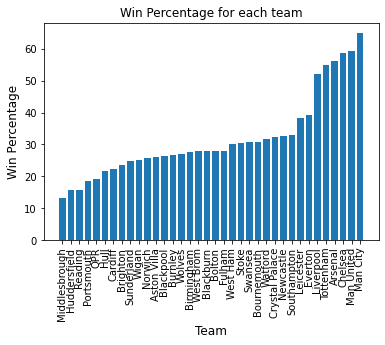

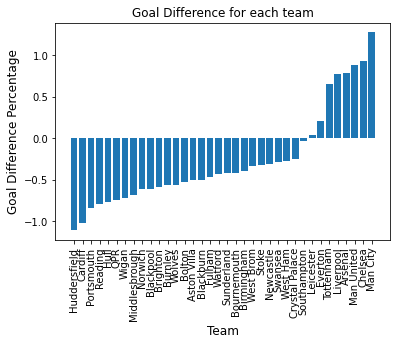

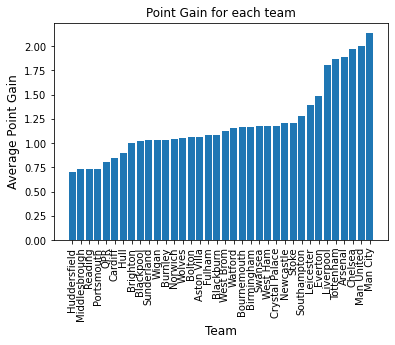

In [97]:
#In order for MatPlotlib to make separate figures, we need a counter
count = 0
#barplot() is a function to make a matplotlib bar chart after providing names
#for the graph and axes as well as providing the data itself
def barplot(title,x_label,y_label,data_labels,data):
  global count #don't treat this as a local variable
  count=count+1 #a new figure is created each time this function is called
  #Notify matplot that this is a separate figure
  plt.figure(count)
  #Add the bar chart title and axis titles
  plt.title(title)
  plt.xlabel(x_label,fontsize=12)
  plt.ylabel(y_label,fontsize=12)
  #Plot the data bars and include the labels on the x-axis
  plt.bar(np.arange(len(data_labels)),data,align='center',alpha=1)
  plt.xticks(np.arange(len(data_labels)),data_labels,rotation='vertical')
  plt.show()


#Observe teams by percentage of wins:

#Avoid modifying original dataframe
win_perc = cum_dataframe.copy() 
#Create a column that shows the percentage of games that are wins
win_perc['WP'] = 100*win_perc['W'] / win_perc['Games']
#Sort the data for better (increasing order) visualization
win_perc.sort_values(by="WP",inplace=True)
#Create the bar chart
barplot("Win Percentage for each team","Team","Win Percentage",win_perc.index.values,win_perc.WP.values)


#Observe teams by goal difference:

#Avoid modifying original dataframe
goal_diff = cum_dataframe.copy()
#Create a column that shows the percentage of goals scored minus goals lost
goal_diff['DIFF'] = (goal_diff['G_Scored'] - goal_diff['G_Conceded']) / goal_diff['Games']
#Sort the data for better (increasing order) visualization
goal_diff.sort_values(by="DIFF",inplace=True)
#Create the bar chart
barplot("Goal Difference for each team","Team","Goal Difference Percentage",goal_diff.index.values,goal_diff.DIFF.values)


#Observe teams by Premier league points:
#In Premier League: win -> +3 pts, draw -> +1 pts, loss -> +0 pts 

#Avoid modifying original dataframe
goal_pts = cum_dataframe.copy()
#Create a column that shows the average points gained per game
goal_pts['PTS'] = (3*goal_pts['W'] + goal_pts['D']) / goal_pts['Games']
#Sort the data for better (increasing order) visualization
goal_pts.sort_values(by="PTS",inplace=True)
#Create the bar chart
barplot("Point Gain for each team","Team","Average Point Gain",goal_pts.index.values,goal_pts.PTS.values)

Despite these being slightly different metrics, the (almost) same ranking of teams tends to transcend all of the graphs. This shows that these teams are in a strong hierarchy since this ranking of teams remains even when comparing different metrics. In that case, the teams aren't very equally matched if certain teams can dominate over other teams in all categories. These graphs aren't very reassuring for the teams on the left since they are only acheiving a fraction of what the top teams are acheiving.

**Selecting Best Teams**

We want to isolate the top 6 teams (based on the metrics shown above) so 
that we can do deeper analysis on the most successful teams. The teams at 
top of the win percentage, goal difference, and point gain dataframes are 
the best performing ones. Upon observation of the graphs above, we've
chosen the best 6 teams to be:

Man City, Man United, Chelsea, Arsenal, Tottenham, and Liverpool

because they have performed significantly better than other teams.

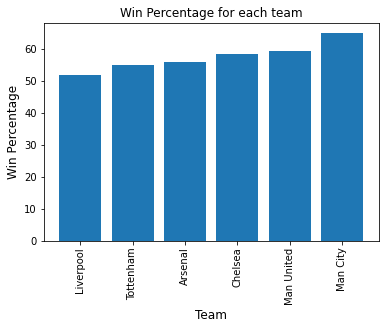

In [98]:
#Keep a list of the top 6 teams to isolate from the other teams
top_teams = ["Man City","Man United","Chelsea","Arsenal","Tottenham","Liverpool"]

#Observe best teams by percentage of wins:

#Restrict dataframe to only best teams
win_perc2 = cum_dataframe[cum_dataframe.index.isin(top_teams)].copy()
#Create a column that shows the percentage of games that are wins
win_perc2['WP'] = 100*win_perc2['W'] / win_perc2['Games']
#Sort the data for better (increasing order) visualization
win_perc2.sort_values(by="WP",inplace=True)
#Create the bar chart
barplot("Win Percentage for each team","Team","Win Percentage",win_perc2.index.values,win_perc2.WP.values)

Although these 6 teams are a lot better than the rest of the teams in the dataframe, they don't seem to be that much better than each other on this bar graph. Therefore, it is fair to be a fan of any of these teams since none of them are significantly better than all the others.

**Analysis of Teams over Time**

We want to see how the performance of the top 6 teams has changed over time. 
The teams have changed in their performance based on factors like new 
coaches being hired or new players being hired. By viewing change in 
performance over time, we can view other factors that change with time 
and see if there is a correlation between these.

In order to get time data, we need more information than the current 
cumulative dataframe because it abstracted away all the information related
to time to summarize aggregate statistics. Therefore, we will now have to  create a cumulative dataframe equivalent for each year.


In [99]:
#This will be a dictionary containing seasons corresponding to a cumulative
#dataframe for that season (aka {season1: cum_data, season2: cum_data, ...})
seasons_dataframes = {}

#First groupby the year to create each season's dataframe each iteration
for s in game_dataframe.groupby(by="season_start"):
  #This dictionary temporarily holds this season's data before transferring it
  season_dict = {}
  #Note that each year, there are different teams in the Premier League, so 
  #we must store the teams for each year
  season_teams = s[1].groupby(by="HomeTeam").groups.keys()
  #Create initialized array for all teams that will be filled later
  for t in season_teams:
    #team: [wins, draws, losses, goals_scored_by, goals_scored_on, shots, ontarget_shots, corners, fouls, yellow_cards, red_cards]
    # g[0]   [0]   [1]     [2]          [3]             [4]         [5]         [6]         [7]     [8]        [9]         [10]
    season_dict[t] = [0,0,0,0,0,0,0,0,0,0,0]


  #Gather data for each team from perspective of home team
  for g in s[1].groupby(by="HomeTeam"):
    #"g[0]" returns the name of the soccer team in the current group
    #Therefore, season_dict[g[0]] accesses values corresponding to that team
    
    
    #Pandas group by has size() to return the number of elements in each group
    outcome_dataframe = g[1].groupby(by="FTR").size().reset_index(name='counts')
    #To avoid errors since sometimes the count of H,D, or A can be 0
    notZero = g[1].groupby(by="FTR").groups.keys()
    #Add win, draw, and loss data for this team to season_dict
    if 'H' in notZero: 
      season_dict[g[0]][0] = season_dict[g[0]][0] + outcome_dataframe[outcome_dataframe["FTR"]=='H']['counts'].iloc[0]
    if 'D' in notZero:
      season_dict[g[0]][1] = season_dict[g[0]][1] + outcome_dataframe[outcome_dataframe["FTR"]=='D']['counts'].iloc[0]
    if 'A' in notZero:
      season_dict[g[0]][2] = season_dict[g[0]][2] + outcome_dataframe[outcome_dataframe["FTR"]=='A']['counts'].iloc[0]

    #np.sum on each column gives us the sum of the values across all matches
    #Add goal, shot, and foul data to relevant spots in season_dict dictionary
    season_dict[g[0]][3] = season_dict[g[0]][3] + np.sum(g[1]['FTHG'])
    season_dict[g[0]][4] = season_dict[g[0]][4] + np.sum(g[1]['FTAG'])
    season_dict[g[0]][5] = season_dict[g[0]][5] + np.sum(g[1]['HS'])
    season_dict[g[0]][6] = season_dict[g[0]][6] + np.sum(g[1]['HST'])
    season_dict[g[0]][7] = season_dict[g[0]][7] + np.sum(g[1]['HC'])
    season_dict[g[0]][8] = season_dict[g[0]][8] + np.sum(g[1]['HF'])
    season_dict[g[0]][9] = season_dict[g[0]][9] + np.sum(g[1]['HY'])
    season_dict[g[0]][10] = season_dict[g[0]][10] + np.sum(g[1]['HR'])


  #Gather data for each team from perspective of away team
  for g in s[1].groupby(by="AwayTeam"):
    #"g[0]" returns the name of the soccer team in the current group
    #Therefore, season_dict[g[0]] accesses values corresponding to that team
    #team: [wins, draws, losses, goals_scored_by, goals_scored_on, shots, ontarget_shots, corners, fouls, yellow_cards, red_cards]
    # g[0]   [0]   [1]     [2]          [3]             [4]         [5]         [6]         [7]     [8]        [9]         [10]

    #Pandas groupby has size() to return the number of elements in each group
    outcome_dataframe = g[1].groupby(by="FTR").size().reset_index(name='counts')
    #To avoid errors since sometimes the count of H,D, or A can be 0
    notZero = g[1].groupby(by="FTR").groups.keys()
    #Add loss, draw, and win data for this team to season_dict
    if 'H' in notZero:
      season_dict[g[0]][2] = season_dict[g[0]][2] + outcome_dataframe[outcome_dataframe["FTR"]=='H']['counts'].iloc[0]
    if 'D' in notZero:
      season_dict[g[0]][1] = season_dict[g[0]][1] + outcome_dataframe[outcome_dataframe["FTR"]=='D']['counts'].iloc[0]
    if 'A' in notZero:
      season_dict[g[0]][0] = season_dict[g[0]][0] + outcome_dataframe[outcome_dataframe["FTR"]=='A']['counts'].iloc[0]

    #np.sum on each column gives us the sum of the values across all matches
    #Add goal, shot, and foul data to relevant spots in season_dict dictionary
    season_dict[g[0]][3] = season_dict[g[0]][3] + np.sum(g[1]['FTAG'])
    season_dict[g[0]][4] = season_dict[g[0]][4] + np.sum(g[1]['FTHG'])
    season_dict[g[0]][5] = season_dict[g[0]][5] + np.sum(g[1]['AS'])
    season_dict[g[0]][6] = season_dict[g[0]][6] + np.sum(g[1]['AST'])
    season_dict[g[0]][7] = season_dict[g[0]][7] + np.sum(g[1]['AC'])
    season_dict[g[0]][8] = season_dict[g[0]][8] + np.sum(g[1]['AF'])
    season_dict[g[0]][9] = season_dict[g[0]][9] + np.sum(g[1]['AY'])
    season_dict[g[0]][10] = season_dict[g[0]][10] + np.sum(g[1]['AR'])

  #Create a dataframe from the dictionary to view data more easily
  season_dataframe = pd.DataFrame.from_dict(season_dict, orient='index', columns=["W","D","L","G_Scored","G_Conceded","Shots","Good_Shots","Corners","Fouls","Ycards","Rcards"])

  seasons_dataframes[s[0]] = season_dataframe;

seasons_dataframes

{2009:               W   D   L  G_Scored  ...  Corners  Fouls  Ycards  Rcards
 Arsenal      23   6   9        83  ...      258    419      56       1
 Aston Villa  17  13   8        52  ...      241    460      61       2
 Birmingham   13  11  14        38  ...      189    408      74       1
 Blackburn    13  11  14        41  ...      182    526      59       2
 Bolton       10   9  19        42  ...      192    519      75       5
 Burnley       8   6  24        42  ...      180    434      57       2
 Chelsea      27   5   6       103  ...      285    441      56       5
 Everton      16  13   9        60  ...      228    462      57       2
 Fulham       12  10  16        39  ...      182    420      46       1
 Hull          6  12  20        34  ...      151    520      67       6
 Liverpool    18   9  11        61  ...      268    445      56       5
 Man City     18  13   7        73  ...      239    402      51       2
 Man United   27   4   7        86  ...      294    421   

Now that we have obtained dataframes of cumulative data for each season, we 
can do some analysis to see if there are correlations in time between a 
team's success and when they were most successful with different factors like shot accuracy, conceding the fewest goals, and penalties.

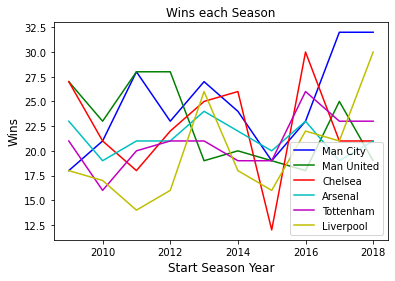

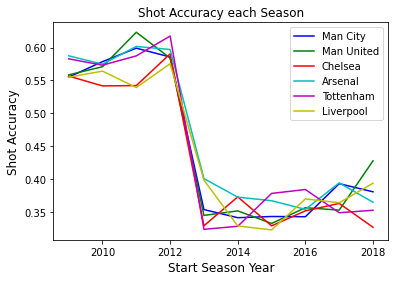

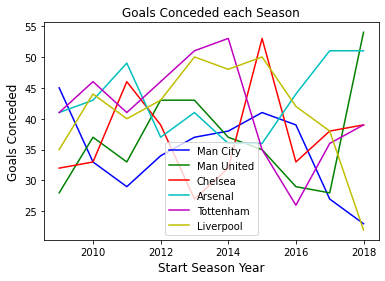

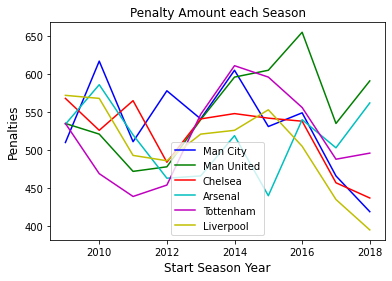

In [100]:
#In order for MatPlotlib to make separate figures, we need a counter
count2 = 0
#lineplot() is a function to make a matplotlib line graph after providing names
#for the graph and axes as well as an array of x and corresponding y values
#(but these y values are in the form of a dictionary of {label:[y points],...}
#to allow the user to plot multiple labeled lines on same plot) and colors with
#the same dictionary system of {label: "color",...}
def lineplot(title,x_label,y_label,xvalues,yvalues,colors):
  global count2 #don't treat this as a local variable
  count2=count2+1 #a new figure is created each time this function is called
  #Notify matplot that this is a separate figure
  plt.figure(count2)
  #Add the bar chart title and axis titles
  plt.title(title)
  plt.xlabel(x_label,fontsize=12)
  plt.ylabel(y_label,fontsize=12)
  #Plot the data for each time at a time
  for k in yvalues.keys():
    plt.plot(xvalues,yvalues[k],colors[k])

  #Add a legend to label lines
  plt.legend(yvalues.keys())
  plt.show()



#All the plots below use same x values, so we calculate it once here
years = list(seasons_dataframes.keys())
#We also want to keep a consistent color scheme for the teams
colorlist = ['b','g','r','c','m','y']
colorscheme = dict(zip(top_teams,colorlist))

#Since we know each team plays the same number of games per season (38), we 
#don't need to standardize by dividing by the number of games


# win line plot

#Create dictionary to store win values for each team for each season:
#{team:[wins_season1,wins_season2,...],...}
win_time = {}
#Iterate through teams
for t in top_teams:
  #Initialize empty array for this team's y values
  win_time[t] = []
  #Go through all seasons and add win data to dictionary value
  for sd in seasons_dataframes.values():
    win_time[t].append(sd[sd.index==t]['W'][0])

#Create a lineplot of wins vs time for all teams
lineplot("Wins each Season","Start Season Year","Wins",years,win_time,colorscheme)


# shot target accuracy

#Create dictionary to store shot accuracy values for each team for each season:
#{team:[accuracy_season1,accuracy_season2,...],...}
shot_time = {}
#Iterate through teams
for t in top_teams:
  #Initialize empty array for this team's y values
  shot_time[t] = []
  #Go through all seasons and add shot accuracy data to dictionary value
  for sd in seasons_dataframes.values():
    shot_time[t].append(sd[sd.index==t]['Good_Shots'][0] / sd[sd.index==t]['Shots'][0])

#Create a lineplot of shot accuracy vs time for all teams
lineplot("Shot Accuracy each Season","Start Season Year","Shot Accuracy",years,shot_time,colorscheme)


# goal concedance

#Create dictionary to store goals conceded for each team for each season:
#{team:[conceded_season1,conceded_season2,...],...}
conc_time = {}
#Iterate through teams
for t in top_teams:
  #Initialize empty array for this team's y values
  conc_time[t] = []
  #Go through all seasons and add goals conceded data to dictionary value
  for sd in seasons_dataframes.values():
    conc_time[t].append(sd[sd.index==t]['G_Conceded'][0])

#Create a lineplot of goals conceded vs time for all teams
lineplot("Goals Conceded each Season","Start Season Year","Goals Conceded",years,conc_time,colorscheme)

# penalties

#Create dictionary to store penalties for each team for each season:
#{team:[penalties_season1,penalties_season2,...],...}
penalty_time = {}
#Iterate through teams
for t in top_teams:
  #Initialize empty array for this team's y values
  penalty_time[t] = []
  #Go through all seasons and add penalty data to dictionary value
  for sd in seasons_dataframes.values():
    penalty_amount = sd[sd.index==t]['Fouls'][0] + 2*sd[sd.index==t]['Ycards'][0]+3*sd[sd.index==t]['Rcards'][0]
    penalty_time[t].append(penalty_amount)

#Create a lineplot of penalties vs time for all teams
lineplot("Penalty Amount each Season","Start Season Year","Penalties",years,penalty_time,colorscheme)

These line graphs are very jumpy because the data between the years is discrete instead of continuous, making it a little hard to follow. But, if we follow a single team like Manchester City, we notice that there are negative correlations between the wins and the goals conceded or penalties. The dark blue line for Manchester City is frequently travelling in opposite directions between these charts. This makes sense because having a lower number of goals conceded and penalties means that the team is better at defending and not losing players from penalties. This negative correlation is also visible if we observe Chelsea since the spikes between the wins graph and goals conceded graph almost look like vertically mirrored images.

As a side note, there is a significant jump in the data for shot accuracy for all teams during 2013. This dramatic shift is not a reflection of a sudden change among many teams, but rather is due to the definition of an "on target" shot changing to be more strict. As a result, even though the teams' general accuracies didn't really change, they appear as if they went downhill. 

**Referee bias**

Note: Let us see if this is necessary

Just like any other major sports league, referees play a very important role in deciding the fate of every game, and potentially the winners of the league itself.

Sometimes some referees tend to be biased against certain clubs. One famous example of this case is the relationship between Chelsea FC and Referee Anthony Taylor. 

For more info : https://www.sportbible.com/football/football-news-thread-of-anthony-taylors-wrong-decisions-against-chelsea-is-longer-20210828

<!-- Frustration by Chelsea fans: -->
<!-- 1) https://www.youtube.com/watch?v=MdcVhoQ--0I -->

<!--2) https://www.youtube.com/watch?v=dz28UJOCVjI -->

<!-- Note: may need to remove before submitting -->


Let us try to analyze our game_database and confirm/reject the claims of Chelsea fans.



Chelsea receiving foul average is 11.772727272727273 in 22 games
Other receiving foul average is 10.67674418604651 in 430 games


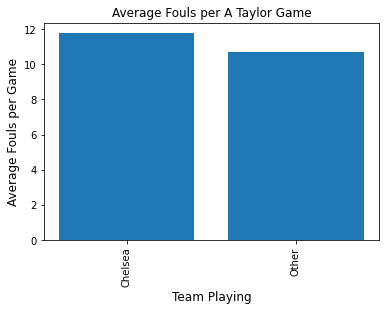

In [101]:
#Create a dataframe with only games that A Taylor was the ref for
games_Taylor = game_dataframe.loc[game_dataframe['Referee'] == 'A Taylor']

#Keep track of Chelsea's fouls from A Taylor
chelsea_fouls = []
#Keep track of fouls for all other teams from A Taylor
other_fouls = []
for index, row in games_Taylor.iterrows():
  home = row['HomeTeam'] #store home team as 'home'
  away = row['AwayTeam'] #store away team as 'away'
  hf = row['HF'] #home fouls
  af = row['AF'] #away fouls

  if home == 'Chelsea': #If Chelsea played as Home team
    chelsea_fouls.append(int(hf)) #Add Chelsea's fouls when they were home team
    other_fouls.append(int(af)) #Add other team fouls
  elif away == 'Chelsea': #If Chelsea played as Away team
    chelsea_fouls.append(int(af)) #Add Chelsea's fouls when they were away team
    other_fouls.append(int(hf)) #Add other team fouls
  else: #If Chelsea was neither the home or away team
    other_fouls.append(int(hf)) #Add other team fouls
    other_fouls.append(int(af)) #Add other team fouls

#We want to see if the average number of fouls in a game that Chelsea plays is 
#greater than the average number of fouls in a game that any other team plays.
print(f"Chelsea receiving foul average is {np.mean(chelsea_fouls)} in {len(chelsea_fouls)} games")
print(f"Other receiving foul average is {np.mean(other_fouls)} in {len(other_fouls)} games")

#Create a bar plot of the above data
barplot("Average Fouls per A Taylor Game","Team Playing","Average Fouls per Game",["Chelsea","Other"],[np.mean(chelsea_fouls),np.mean(other_fouls)])

Looking at the above result, we can say that if we consider all games officiated by Taylor, more fouls were awarded against Chelsea.
However, this does not confirm that Taylor is biased against Chelsea. It could be that Chelsea tends to commit more fouls than other teams.
Let's do our analysis a little different here. Let's look at all Chelsea games, and compare the number of fouls in games officiated by Taylor
against the number of fouls in games officiated by other referees.

Average fouls in games officiated by Taylor is 11.772727272727273 in 22 games
Average fouls in games not officiated by Taylor is 10.243016759776536 in 358 games


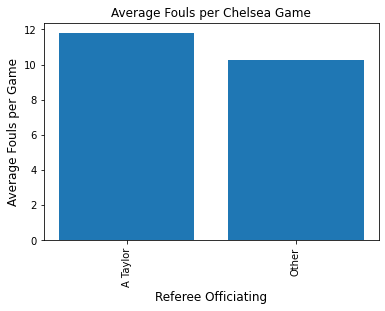

In [102]:
#Create a dataframe of only Chelsea's games
games_Chelsea = game_dataframe.loc[(game_dataframe['HomeTeam'] == 'Chelsea') | (game_dataframe['AwayTeam'] == 'Chelsea')]

#Keep track of fouls from A Taylor
fouls_Taylor = []
#Keep track of fouls from other referees
fouls_other = []

#Iterate through all of Chelsea's games
for index, row in games_Chelsea.iterrows():

  #Getting the fouls committed by Chelsea for this game (row)
  if row['HomeTeam'] == 'Chelsea': #If Chelsea was home team
    num_fouls = row['HF'] #Set fouls to home team fouls
  else: #If Chelsea was away team
    num_fouls = row['AF'] #Set fouls to away team fouls

  #Putting that number in the right list depending on who the referee is
  if row['Referee'] == 'A Taylor':
    fouls_Taylor.append(num_fouls) #Add A Taylor's fouls
  else: #If the referee wasn't A Taylor
    fouls_other.append(num_fouls) #Add other referee's fouls

#We want to see if Chelsea games officiated by Taylor recieved more fouls than 
#Chelsea games officiated by other referees.
print(f'Average fouls in games officiated by Taylor is {np.mean(fouls_Taylor)} in {len(fouls_Taylor)} games')
print(f'Average fouls in games not officiated by Taylor is {np.mean(fouls_other)} in {len(fouls_other)} games')

#Create a bar plot of the above data
barplot("Average Fouls per Chelsea Game","Referee Officiating","Average Fouls per Game",["A Taylor","Other"],[np.mean(fouls_Taylor),np.mean(fouls_other)])

We can see that a lot more fouls are given against Chelsea in games officiated by Anthony Taylor compared to other games. The data indicates that there is an increase in fouls against Chelsea when Anthony Taylor is the referee. Also, there is an increase in fouls given by Anthony Taylor against Chelsea.

**Home and Away teams**

Like all sports, home advantage is an integral part of football and can be enough to decide games. 

Let us try to see how teams perform when they are playing at home compared to when they are playing away from home.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


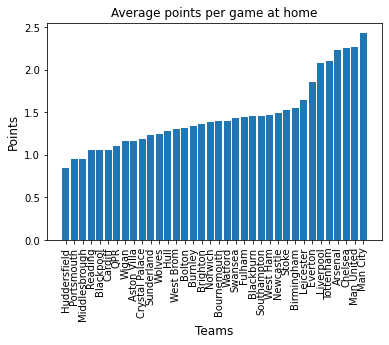

In [103]:
#Create dataframe of only the hometeam and the game outcome ("FTR")
home_performance = game_dataframe[['HomeTeam', 'FTR']]
home_performance['num_games'] = 1   #Will be used to count number of games
home_performance['points'] = 0      #Will denote number of points achieved in that game based on result
#Iterate through all home games
for index, row in home_performance.iterrows():
  if row['FTR'] == 'H':
    home_performance.at[index, 'points'] = 3  #three points for a win
  elif row['FTR'] == 'D':
    home_performance.at[index, 'points'] = 1  #one point for a draw

    #Since it's 0 points for a loss, we don't have to make if branch

#Drop the game outcome column since it isn't used anymore
home_performance = home_performance.drop('FTR', axis=1)
#This will take the sum of all entries in the 'num_games' column and the 
#'points' column which represents the total number of home games and the total 
#number of points scored by the team when it was playing at home, respectively
home_performance = home_performance.groupby(by='HomeTeam').sum()
#We can find the average number of points per game by dividing total pts / games
home_performance['avg_points'] = home_performance['points']/home_performance['num_games']
#Sort the data for better (increasing) visualization
home_performance.sort_values(by='avg_points', inplace=True)

#Create a barplot of the above data
barplot('Average points per game at home', 'Teams', 'Points', home_performance.index, home_performance['avg_points'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


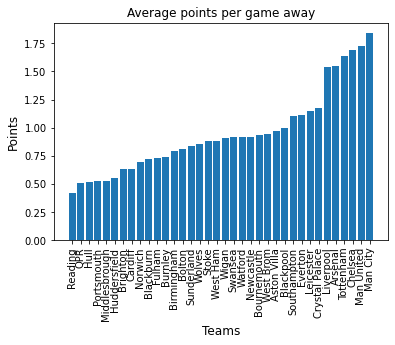

In [104]:
#Create dataframe of only the awayteam and the game outcome ("FTR")
away_performance = game_dataframe[['AwayTeam', 'FTR']]
away_performance['num_games'] = 1   #Will be used to count number of games
away_performance['points'] = 0      #Will denote number of points achieved in that game based on result
#Iterate through all away games
for index, row in away_performance.iterrows():
  if row['FTR'] == 'A':
    away_performance.at[index, 'points'] = 3  #three points for a win
  elif row['FTR'] == 'D':
    away_performance.at[index, 'points'] = 1  #one point for a draw

#Drop the game outcome column since it isn't used anymore
away_performance = away_performance.drop('FTR', axis=1)
#This will take the sum of all entries in the 'num_games' column and the 
#'points' column which represents the total number of away games and the total 
#number of points scored by the team when it was playing away, respectively
away_performance = away_performance.groupby(by='AwayTeam').sum()
#We can find the average number of points per game by dividing total pts / games
away_performance['avg_points'] = away_performance['points']/away_performance['num_games']
#Sort the data for better (increasing) visualization
away_performance.sort_values(by='avg_points', inplace=True)

#Create a barplot of the above data
barplot('Average points per game away', 'Teams', 'Points', away_performance.index, away_performance['avg_points'])

It is pretty evident that all teams perform significantly better when they play as the home team rather than the away team. For many of these teams, they gained as much as 1.5 - 2 times more points at home than they did away.

As discussed before, this "home advantage" isn't limited to football either. In fact it has been seen in basketball, baseball, and (throwing) football too: https://cupola.gettysburg.edu/cgi/viewcontent.cgi?article=1689&context=student_scholarship

**Player Analysis**

So far, we've observed at a high level which teams have been successful, but
we should also observe the players on each team to see if they have an 
effect on how often each team wins. In order to do this, we collected both
physical data (height, age) as well as skill data (speed, position, 
attack/defense capabilities) for all the players in the Premier League.
Unfortunately, since there was no CSV file and BeautifulSoup wasn't working,
we had to do manual webscraping using JavaScript for the online PES dataset.
PES DATASET: https://www.pesmaster.com/efootball-2022/search/?league=113

In [105]:
# //JAVASCRIPT CODE
# var data = {}; //JavaScript object to store all data
# //Have a reference to the table containing all data
# var table = document.getElementById("search-result-table");
#
# //Get a list of the column names of the table
# var headers = document.getElementsByClassName("headcol topcol");
# for (var i=0; i<headers.length; i++){
#     data[headers[i].getElementsByTagName("span")[0].innerHTML] = [];
# }
#
# //Iterate through all table rows and then extract/add relevant data
# var rows = table.getElementsByTagName("tbody")[0].getElementsByTagName("tr");
# for (var i=0; i<rows.length; i++){
#     var attributes = rows[i].getElementsByTagName("td");
#
#     data['Name'].push(attributes[0].getElementsByTagName("a")[0].innerHTML);
#     data['Club'].push(attributes[1].getElementsByTagName("img")[0].getAttribute("title"));
#     data['Nationality'].push(attributes[2].getElementsByTagName("img")[0].getAttribute("title"));
#     data['Age'].push(attributes[3].innerHTML);
#     data['Height'].push(attributes[4].innerHTML);
#     data['Position'].push(attributes[5].getElementsByTagName("span")[0].innerHTML);
#     data['Overall'].push(attributes[6].getElementsByTagName("span")[0].innerHTML);
#     data['Low Pass'].push(attributes[7].getElementsByTagName("span")[0].innerHTML);
#     data['Finishing'].push(attributes[8].getElementsByTagName("span")[0].innerHTML);
#     data['Physical Contact'].push(attributes[9].getElementsByTagName("span")[0].innerHTML);
#     data['Defensive Awareness'].push(attributes[10].getElementsByTagName("span")[0].innerHTML);
#     data['Speed'].push(attributes[11].getElementsByTagName("span")[0].innerHTML);
#     data['Dribbling'].push(attributes[12].getElementsByTagName("span")[0].innerHTML);
# }
#
# console.log(JSON.stringify(data));
# //END OF JAVASCRIPT CODE

#The output from this was stored as a JSON object file (currently stored
#on one of our github pages) for ease of converting this to a dataframe

In [106]:
#Load the JSON file (if it's not there) with player data onto google colab
!if [ ! -f player.json ]; then wget https://raw.githubusercontent.com/Dgunawardana/FootballAnalysis/main/player.json; fi

#Use Python's JSON load function to convert json file to dictionary
f = open("player.json","r")
player_dict = json.load(f)
f.close()

#Create a dataframe from the player dictionary
player_dataframe = pd.DataFrame.from_dict(player_dict)
#Do a little data cleaning: store numbers as ints rather than strings
for n in player_dataframe.columns:
  if not n in ['Name','Club','Nationality','Position']:
    player_dataframe[n] = player_dataframe[n].astype(int)
player_dataframe.head(20)

,Name,Club,Nationality,Age,Height,Position,Overall,Low Pass,Finishing,Physical Contact,Defensive Awareness,Speed,Dribbling
0,Cristiano Ronaldo,Manchester United,Portugal,36,187,CF,92,76,81,78,45,78,83
1,K. De Bruyne,Manchester City,Belgium,30,181,AMF,91,88,75,69,58,75,78
2,H. Kane,Tottenham Hotspur,England,28,188,CF,90,76,88,79,45,72,75
3,V. van Dijk,Liverpool,Netherlands,30,193,CB,90,70,49,87,90,73,61
4,R. Lukaku,Chelsea,Belgium,28,191,CF,89,67,82,88,51,82,73
5,M. Salah,Liverpool,Egypt,29,175,RWF,89,72,78,65,42,87,80
6,N. Kanté,Chelsea,France,30,168,DMF,89,81,64,68,84,79,75
7,Alisson,Liverpool,Brazil,29,191,GK,89,63,40,73,46,58,50
8,S. Mané,Liverpool,Senegal,29,175,LWF,88,67,74,66,44,88,80
9,Bruno Fernandes,Manchester United,Portugal,27,179,AMF,88,83,77,61,53,72,75


Player Dataframe Description

In this dataframe, the columns are name, club, country of origin, age, height, position, overall, passing ability, finishing, physical contact, defensive awareness, speed, and dribbling. Most of these aspects are pretty self-explanatory, but "low pass" is just a way to indicate how good a player is at passing the ball on the ground and "finishing" is how easily the player can score. The "physical contact" shows how strong a player is (whether they can keep balance when pushing another player) and "Defensive Awareness" is how fast a player responds defensively to the ball. Note that "club" is the same thing as team.

A more comprehensive guide to the typical skills that players are measured by can be found here: https://pesmyclubguide.com/player-attributes/

Here is a cheat sheet for football positions and their abbreviations:
http://sportsgiz.com/football/football-soccer-field-player-positions-abbreviations/

Now that we have all the player data for the Premier League in one unified 
dataset, we can try to find correlations between the abilities of players
and the wins of each team. Perhaps, there are certain traits that are more 
important when it comes to winning. The dataset contains trait information
like passing capability, speed, dribbling, finishing, and defensive 
awareness. We can try to find which of these factors has the strongest 
relationship to win percentage via cosine similarity. We can do this by having a vector for both the winning percentage for each team and another vector for the traits, where each dimension corresponds to a team and the value in that dimension is either the trait we're measuring or win percentage. To quantify a team's potential for a given trait, we will take the average of the top 10 players' scores for that trait on that team.

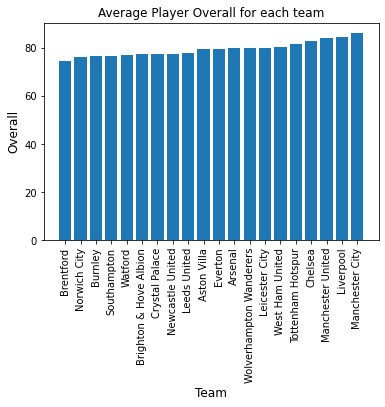

The similarity to wins for Overall is 0.843271416661522


In [107]:
#Since many of the next steps involve observing teams individually
team_players = player_dataframe.groupby(by="Club")
#Get a list of the teams to compare to
teams = player_dataframe["Club"].unique()
#Win_vec will be the standard for comparison of the traits
win_vec = dict(zip(win_perc.index.values,win_perc.WP.values))

#The game_dataframe dataset and the players_dataframe use slightly different 
#naming conventions for a few teams, so that had to be fixed manually
convert = {"Man United":"Manchester United","Man City":"Manchester City",
           "Tottenham":"Tottenham Hotspur","Leicester":"Leicester City",
           "Newcastle":"Newcastle United","West Ham":"West Ham United",
           "Wolves":"Wolverhampton Wanderers","Brighton":"Brighton & Hove Albion",
           "Norwich":"Norwich City"}

#Note that Leeds and Brentford weren't found in game_dataframe 

#Convert the team name in the game dataframe to its alias in player dataframe
for k in convert.keys():
  win_vec[convert[k]] = win_vec[k]
  #Delete the unused key
  del win_vec[k]

#This function takes in 2 dictionaries and outputs a number between -1 and 1 to 
#indicate how similar their values are (positive 1 indicates high similarity). 
#The dictionary keys are the dimensions (teams) and the values of the keys are
#the values in each dimension.
def COSsimilarity(a,b):
  #These two lists will become vector representations of a and b, where only
  #dimensions that are shared (same keys) will be added
  a_int = []
  b_int = []
  #Iterate through all of a's keys
  for k in a.keys():
    #If a key is in both a and b
    if k in b.keys():
      #Add the values corresponding to this key as a new dimension 
      a_int.append(a[k])
      b_int.append(b[k])

  #Convert to numpy array for ease of computation
  VecA = np.array(a_int)
  VecB = np.array(b_int)

  #Standardize the vectors by subtracting all entries by the average value
  #This leads to a greater difference in cosine similarity since now not all
  #values in both vectors are high positive numbers (falsely high similarity).
  VecA = VecA - np.mean(VecA)
  VecB = VecB - np.mean(VecB)

  #Return Cosine similarity of these two vectors using numpy
  return np.dot(VecA,VecB) / ((np.linalg.norm(VecA))*(np.linalg.norm(VecB)))



#To confirm that having better overall players translates to having more wins

#Dictionary that will store Overall data for each team
overall = {}
#Iterate through all team groups in player dataframe
for g in team_players:
  #Sort this group's dataframe by Overall
  g[1].sort_values(by="Overall",inplace=True,ascending=False)
  #Find the average of the team's Overall score across the top 10 players
  overall[g[0]] = [np.mean(g[1]['Overall'].values[1:11])]
#Create a dataframe from dictionary for easy sorting
overall_df = pd.DataFrame.from_dict(overall,orient='index',columns=['Score'])
overall_df.sort_values(by='Score',inplace=True,ascending=True)

#Create a barchart for all teams
barplot("Average Player Overall for each team","Team","Overall",overall_df.index.values,overall_df.Score.values)
print(f"The similarity to wins for Overall is {COSsimilarity(win_vec,dict(zip(overall_df.index.values,overall_df.Score.values)))}")

  


Unsuprisingly, the average overall score of the top ten players of a team 
does correlate well with winning percentage. But there are other traits to 
test. We can use this same test to see if one trait is necessarily a better 
indicator of winning percentage than another (if that trait has a relatively 
higher cosine similarity). Therefore, we will now check if passing
capability, speed, dribbling, finishing, or defensive awareness are better 
indicators of winning percentage.

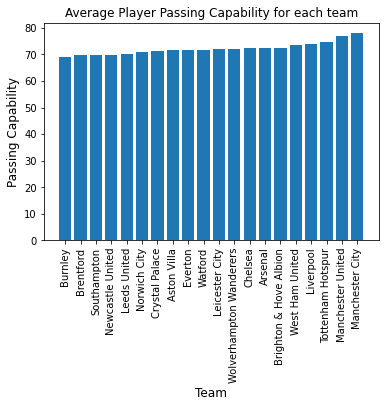

The similarity to wins for passing is 0.7239242680996479



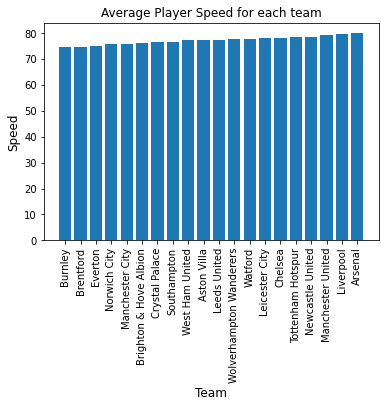

The similarity to wins for speed is 0.49517546056038075



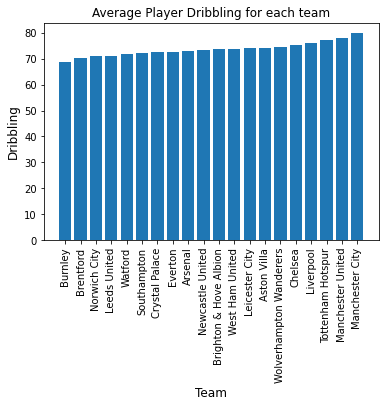

The similarity to wins for dribbling is 0.7399635680155696



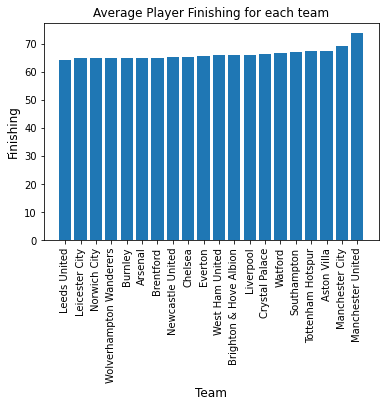

The similarity to wins for finishing is 0.4772103041642479



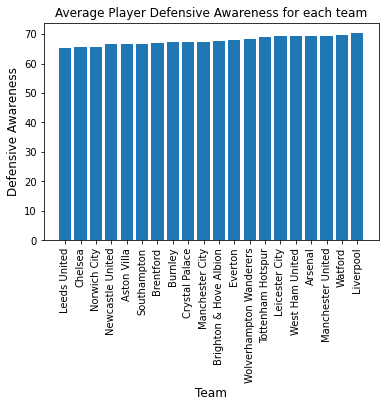

The similarity to wins for defensive awareness is 0.26760797468913955


In [108]:
#Check if Passing Capability correlates more

#Dictionary that will store Passing Capability data for each team
passing = {}
#Iterate through all teams
for g in team_players:
  #Sort this group's dataframe by Low Pass
  g[1].sort_values(by="Low Pass",inplace=True,ascending=False)
  #Find the average of the team's Low Pass score across the top 10 players
  passing[g[0]] = [np.mean(g[1]['Low Pass'].values[1:11])]
#Create a dataframe from dictionary for easy sorting
passing_df = pd.DataFrame.from_dict(passing,orient='index',columns=['Score'])
passing_df.sort_values(by='Score',inplace=True,ascending=True)

#Create a barchart for all teams
barplot("Average Player Passing Capability for each team","Team","Passing Capability",passing_df.index.values,passing_df.Score.values)
print(f"The similarity to wins for passing is {COSsimilarity(win_vec,dict(zip(passing_df.index.values,passing_df.Score.values)))}")
print()


#Check if Speed correlates more

#Dictionary that will store Speed data for each team
speed = {}
#Iterate through all teams
for g in team_players:
  #Sort this group's dataframe by Speed
  g[1].sort_values(by="Speed",inplace=True,ascending=False)
  #Find the average of the team's Speed score across the top 10 players
  speed[g[0]] = [np.mean(g[1]['Speed'].values[1:11])]
#Create a dataframe from dictionary for easy sorting
speed_df = pd.DataFrame.from_dict(speed,orient='index',columns=['Score'])
speed_df.sort_values(by='Score',inplace=True,ascending=True)

#Create a barchart for all teams
barplot("Average Player Speed for each team","Team","Speed",speed_df.index.values,speed_df.Score.values)
print(f"The similarity to wins for speed is {COSsimilarity(win_vec,dict(zip(speed_df.index.values,speed_df.Score.values)))}")
print()


#Check if Passing Dribbling correlates more

#Dictionary that will store Dribbling data for each team
dribbling = {}
#Iterate through all teams
for g in team_players:
  #Sort this group's dataframe by Dribbling
  g[1].sort_values(by="Dribbling",inplace=True,ascending=False)
  #Find the average of the team's Dribbling score across the top 10 players
  dribbling[g[0]] = [np.mean(g[1]['Dribbling'].values[1:11])]
#Create a dataframe from dictionary for easy sorting
dribbling_df = pd.DataFrame.from_dict(dribbling,orient='index',columns=['Score'])
dribbling_df.sort_values(by='Score',inplace=True,ascending=True)

#Create a barchart for all teams
barplot("Average Player Dribbling for each team","Team","Dribbling",dribbling_df.index.values,dribbling_df.Score.values)
print(f"The similarity to wins for dribbling is {COSsimilarity(win_vec,dict(zip(dribbling_df.index.values,dribbling_df.Score.values)))}")
print()


#Check if Finishing correlates more

#Dictionary that will store Finishing data for each team
finishing = {}
#Iterate through all teams
for g in team_players:
  #Sort this group's dataframe by Finishing
  g[1].sort_values(by="Finishing",inplace=True,ascending=False)
  #Find the average of the team's Finishing score across the top 10 players
  finishing[g[0]] = [np.mean(g[1]['Finishing'].values[1:11])]
#Create a dataframe from dictionary for easy sorting
finishing_df = pd.DataFrame.from_dict(finishing,orient='index',columns=['Score'])
finishing_df.sort_values(by='Score',inplace=True,ascending=True)

#Create a barchart for all teams
barplot("Average Player Finishing for each team","Team","Finishing",finishing_df.index.values,finishing_df.Score.values)
print(f"The similarity to wins for finishing is {COSsimilarity(win_vec,dict(zip(finishing_df.index.values,finishing_df.Score.values)))}")
print()


#Check if Defensive Awareness correlates more

#Dictionary that will store Defensive Awareness data for each team
defensive = {}
#Iterate through all teams
for g in team_players:
  #Sort this group's dataframe by Defensive Awareness
  g[1].sort_values(by="Defensive Awareness",inplace=True,ascending=False)
  #Find the average of the team's Defensive Awareness score across the top 10 players
  defensive[g[0]] = [np.mean(g[1]['Defensive Awareness'].values[1:11])]
#Create a dataframe from dictionary for easy sorting
defensive_df = pd.DataFrame.from_dict(defensive,orient='index',columns=['Score'])
defensive_df.sort_values(by='Score',inplace=True,ascending=True)

#Create a barchart for all teams
barplot("Average Player Defensive Awareness for each team","Team","Defensive Awareness",defensive_df.index.values,defensive_df.Score.values)
print(f"The similarity to wins for defensive awareness is {COSsimilarity(win_vec,dict(zip(defensive_df.index.values,defensive_df.Score.values)))}")


Observing the graphs above, the most successful teams are the ones that choose the players with the best dribbling and passing skills since these had a 72% and 74% cosine similarity to the vector of the teams' win percentages. Speed and Finishing skills seemed a little less important since they were each around 50% in cosine similarity, but Defensive Awareness seems to be the least useful skill. Therefore, coaches should invest in players with good dribbling and passing abilities.

At this point we have roughly figured out what tends to correlate pretty 
well with winning percentage of teams. We can now use this information to 
create predictions about the outcome of one team playing another team or how
a team will perform in a future season.

**Prediction 1**

We will begin prediction by using a simple linear regression model that 
takes in the goals scored, goals conceded, shots, shots on target, and 
fouls from the previous year and then have the model output the predicted
number of games that team will win next year. Then we will also use an SVM to see if it has better accuracy.

According to the model, the expected number of wins a team will have next year is:
 0.1843085470095371*(Goals scored) + -0.14235741396307666*(Goals conceded) + 0.014530660520168368*(Shots) + -0.003595964151188971*(Shots on target) + 0.00032292275028841105*(Fouls)

The linear model predictions are around 80.25075124656534% accurate for each guess
The svm predictions are around 72.10763140447365% accurate for each guess


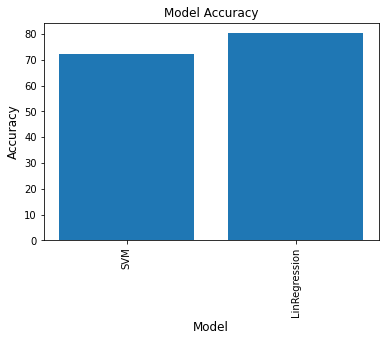

In [109]:
#Create the training data 
X = [] #This will contain all input data
Y = [] #This will contain all labels for each input
#Iterate through all the dataframes
for k in seasons_dataframes.keys():
  if k != 2018: #Since 2018 is the last dataset we have, we don't have the
                #labels for this input data (we would need 2019 data)
    df = seasons_dataframes[k]
    #Iterate through all teams in 
    for t,row in df.iterrows():
      #Only focus on team 't' if it also exists in next year's dataframe
      if t in seasons_dataframes[k+1].index.values:
        #Add the label, which is the number of wins next year
        Y.append(seasons_dataframes[k+1].loc[t]['W'])
        #Add the input, which is the parameters shown below
        X.append([row['G_Scored'],row['G_Conceded'],row['Shots'],row['Good_Shots'],row['Fouls']])

#We need to partition the input data and labels to be able to evaluate accuracy
Xtrain = [] #Training input data
Ytrain = [] #Training output data
Xtest = [] #Testing input data
Ytest = [] #Testing output data
TrainProportion = 0.7 #Train with 70% of data, test with 30%

#This section splits the input and labels data into the partitions
for i in range(0,len(X)):
  #We use psuedorandom code to randomly place each data point in either the 
  #training or testing data (but more likely to land in training)
  #random.random() generates a float in [0,1)
  if random.random() > TrainProportion:
    Xtest.append(X[i])
    Ytest.append(Y[i])
  else:
    Xtrain.append(X[i])
    Ytrain.append(Y[i])

#Use a linear regression model
mod1 = linear_model.LinearRegression()
#Train the model using the training data
mod1.fit(Xtrain,Ytrain)
#View model parameters
b = mod1.intercept_
(a0,a1,a2,a3,a4) = mod1.coef_
print(f"According to the model, the expected number of wins a team will have \
next year is:\n {a0}*(Goals scored) + {a1}*(Goals conceded) + {a2}*(Shots) + \
{a3}*(Shots on target) + {a4}*(Fouls)")


#Use an SVM model
mod2 = svm.SVR()
#Train the model using the training data
mod2.fit(Xtrain,Ytrain)


#Evaluate Accuracy
error1 = 0 #Linear Regression Error will be cumulative across all guesses
error2 = 0 #SVM Error will be cumulative across all guesses
#Iterate through all test data
for i in range(0,len(Xtest)):
  #Use the linear model to make a guess based on input data
  guess1 = mod1.predict([Xtest[i]])
  #Use the SVM model to make a guess based on input data
  guess2 = mod2.predict([Xtest[i]])
  #Add the error from this guess to the cumulative amount of error.
  #We use the percentage by which the guess was off from the actual answer
  #as our metric because then the error / number of guesses should give
  #us the average percentage by which the model fails.
  error1 = error1 + 100*abs((guess1 - Ytest[i])/Ytest[i])
  error2 = error2 + 100*abs((guess2 - Ytest[i])/Ytest[i])

print()
#We do 100 - percentage by which model fails for ease of interpretability
print(f"The linear model predictions are around {100 - (error1[0] / len(Xtest))}% accurate for each guess")
print(f"The svm predictions are around {100 - (error2[0] / len(Xtest))}% accurate for each guess")
barplot("Model Accuracy","Model","Accuracy",["SVM","LinRegression"],[(100 - (error2[0] / len(Xtest))),(100 - (error1[0] / len(Xtest)))])

  While the Linear Regression model wasn't bad (it typically scored around
*70-80% accuracy*), it could probably be more accurate if we fed it different
parameters. When looking at the regression equation, it makes sense for 
there to be a positive slope for goals scored and shots since higher values
in those categories imply a more successful team. It also makes sense for
the goals conceded and the fouls to have negative slopes because a team 
that gets more of those is probably worse at defending, and could even lose
players if those fouls translate to red cards. However, it makes no sense 
for shots on target--that is, teams that have accurate shooters--to have a
negative slope since a team that is more accurate with shooting should do
better. That seems to be one fault with this model, but judging by the 
much larger slopes of the goal related parameters compared to the slopes of 
the other parameters, it seems that the prediction is instead dominated by goals scored/conceded.

The SVM seems to be consistently worse than the Linear Regression model at an *accuracy of roughly 65-75%*. Therefore, for the sake of this regression problem, we would likely choose the Linear Regression model over the SVM.


**Prediction 2**

Now we want to try predicting the outcome of games between two teams. We can 
use most of the same input data for the previous machine learning model. 
Considering how small the coefficients were for the shots on target parameter
and the fouls parameter, we won't use those in the input since they don't seem
to have much of an effect on the prediction. Another modification is that we
will be feeding the input data of goals scored/conceded and shots for both 
teams (instead of just one) as well as which team is home/away. As we 
demonstrated above, there is quite an advantage for the home team. So we
will feed this input data into tree and k-nearest neighbors classification models and evaluate their accuracies.


The accuracy of the Decision Tree is 0.499009900990099
The accuracy of the K-Nearest Neighbors is 0.499009900990099


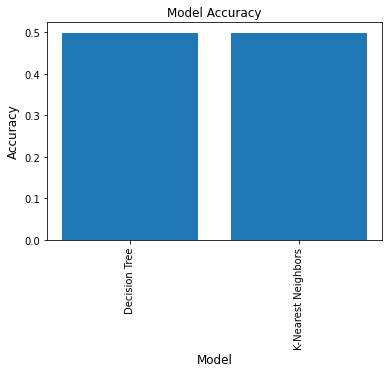

In [110]:
#Create the training data 
X = [] #This will contain all input data
Y = [] #This will contain all labels for each input

#Iterate through all rows of original game_dataframe
for i,row in game_dataframe.iterrows():
  #Keep track of year for season start 
  date = row['season_start']
  #Store name of home team
  th = row['HomeTeam']
  #Store name of away team
  ta = row['AwayTeam']
  #Don't try to use data from 2009 because that would require data from the 2008
  #starting season, which we don't have
  if date != 2009:
    #If both the home team and away team exist in the previous season's df
    if th in seasons_dataframes[date-1].index.values and ta in seasons_dataframes[date-1].index.values:
      #This will contain X's input
      input = []
      #Retreive the dataframe for the previous season
      df = seasons_dataframes[date-1]
      #Gather the relevant input data and add it to X
      input.append(df.loc[th]['G_Scored'])
      input.append(df.loc[th]['G_Conceded'])
      input.append(df.loc[th]['Shots'])
      input.append(df.loc[ta]['G_Scored'])
      input.append(df.loc[ta]['G_Conceded'])
      input.append(df.loc[ta]['Shots'])
      #Gather the label data and append it to Y
      Y.append(row['FTR'])
      X.append(input)


#We need to partition the input data and labels to be able to evaluate accuracy
Xtrain = [] #Training input data
Ytrain = [] #Training output data
Xtest = [] #Testing input data
Ytest = [] #Testing output data
TrainProportion = 0.8 #Train with 80% of data, test with 20%

#This section splits the input and labels data into the partitions
for i in range(0,len(X)):
  #We use psuedorandom code to randomly place each data point in either the 
  #training or testing data (but more likely to land in training)
  #random.random() generates a float in [0,1)
  if random.random() > TrainProportion:
    Xtest.append(X[i])
    Ytest.append(Y[i])
  else:
    Xtrain.append(X[i])
    Ytrain.append(Y[i])


#Create a decision tree model
mod1 = tree.DecisionTreeClassifier(max_depth=5)
#Train the decision tree model
mod1 = mod1.fit(Xtrain,Ytrain)


#Create a k-nearest neighbors model
mod2 = neighbors.KNeighborsClassifier(20)
#Train the k-nearest neighbors model
mod2 = mod2.fit(Xtrain,Ytrain)


#Evaluate Accuracy
error1 = 0 #Decision Tree Error will be cumulative across all guesses
error2 = 0 #K-nearest neighbors Error will be cumulative across all guesses
#Iterate through all test data
for i in range(0,len(Xtest)):
  #Use the Decision Tree to make a guess based on input data
  guess1 = mod1.predict([Xtest[i]])
  #Use the k-nearest neighbors to make a guess based on input data
  guess2 = mod2.predict([Xtest[i]])
  #Keep track of the number of false classifications for both models
  if not guess1 == Ytest[i]:
    error1 = error1 + 1

  if not guess2 == Ytest[i]:
    error2 = error2 + 1

print()
print(f"The accuracy of the Decision Tree is {1 - (error1 / len(Xtest))}")
print(f"The accuracy of the K-Nearest Neighbors is {1 - (error2 / len(Xtest))}")
barplot("Model Accuracy","Model","Accuracy",["Decision Tree","K-Nearest Neighbors"],[(1 - (error1 / len(Xtest))),(1 - (error2 / len(Xtest)))])

Unfortunately, the classification models aren't very accurate (both are around 50%) when they are given just the data on goal , home/away, and shot information. We experimented with different hyperparameters but still couldn't seem to get above a 55% accuracy rate. We settled with a maximum depth of 5 for the decision tree and a k value of 20 for the k nearest neighbors because these values seemed to yield the best accuracy.

We speculate that the reason why the regression, about predicting total goals that were going to be scored in a season, was more accurate than our classification, of which team would win in a single game, was because there is a lot more randomness and unpredictability in a single game than in a season. Over a longer period of time (like a season), activity tends to stabilize and become more predictable because there are more samples (similar to the law of large numbers). However, a game is much more affected by minor random events like weather. Therefore, it is much harder to predict the outcome of an individual game than it is to predict performance over a season.

**Takeaways**

In conclusion, we have shown that football is hard to predict in the short run, but still follows many notable patterns in the long run. One of the biggest factors about whether a team will succeed during a game is if they're playing as the home or away team. Teams experience a major advantage if they play on the same field they practice on, as we've demonstrated on the bar charts comparing the points scored in each condition. Additionally, we showed that referee bias does exist and has an impact on the game. But these are factors beyond the control of the teams. For factors teams do control, like choice of players, they should select the players that not only have a good overall score, but are good at dribbling and passing as these correlated the most with win percentage. Surprisingly, speed wasn't that important. 

The teams Manchester United, Manchester City, Arsenal, Liverpool, Chelsea, and Tottenham have excelled above the other teams in points scored, goal difference, and win percentage. The success of these teams had a light correlation with having a lower number of penalties and goals conceded.

With the power of data analytics, we were able to discover these patterns and confirm existing beliefs about Football. This information can be useful for choosing which teams to follow, as you've now seen the 6 that have dominated in the past decade. Additionally, you (or even a coach) can now see what qualities are useful in a football player. But regardless of whether you're a football fan, or just a curious reader, this data lets us appreciate the complexity of football and why it is such a popular sport throughout the world.